In [1]:
# Tratamiento de datos REGRESION LINEL DECISION TREE
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
#otros
from scipy.stats import chi2_contingency
# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

# Pair Programming Decision Tree

## Ana C y Ana G

En el pair programming de hoy debéis usar el csv que guardastéis cuando hicistéis el pairprgramming de codificicación (este csv debería tener las variables estadandarizas).

En pairprogramming anteriores ajustastéis vuestro datos a una regresión lineal. El objetivo de hoy es:
-  Ajustar el modelo a un Decision Tree
-  Extraer las métricas
-  Debatid entre vosotras que modelo es mejor y por qué (basándose en las métricas)

In [2]:
df = pd.read_csv("../data/08-primas_categorizadas_normalizadas.csv", index_col = 0)
df.shape

(1064, 13)

In [3]:
df2 = pd.read_csv("../data/09-primas-altas.csv", index_col = 0)
df2.shape

(273, 10)

## Primas bajas

In [4]:
# al igual que en la regresión lineal tenemos que separar nuestro dataframe en X e y

X = df.select_dtypes(np.number).drop("charges_Sklearn", axis = 1)
y = df["charges_Sklearn"]

In [5]:
# y dividir nuestros datos en train y test para poder evaluar la bondad de nuestro modelo

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [6]:
# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol = DecisionTreeRegressor(random_state =0)

# ajustamos el modelo, igual que en la regresión lienal. 
arbol.fit(x_train, y_train)



DecisionTreeRegressor(random_state=0)

In [7]:

# max depth

print(arbol.tree_.max_depth)

19


In [8]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

In [9]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo): #FUNCIO PARA METRICAS DE REGRESION
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [10]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results_bajas = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results_bajas

,MAE,MSE,RMSE,R2,set,modelo
0,0.073463,0.035012,0.187114,0.448955,test,Decission Tree I
1,0.000780,0.000259,0.016081,0.995836,train,Decission Tree I


---------------
Recordemos cuando había *overfitting* o *overfitting* 

- Si los valores del *train* son MUCHO MEJOR (que es tener métricas más bajas, excepto en el R² que sería tener valores más altos) que los del *test* --> ***overfitting***. En este caso, nuestro modelo se estaría aprendiendo de memoria los datos de entrenamiento y no sería capaz de hacer buenas predicciones fuera de ese set de datos.

- Si los valores del *train* son MUCHO PEOR (valores de las métricas más altas, excepto en el R² que sería tener valores más bajos) que los del *test* --> ***underfitting***. En este caso, nuestro modelo no es lo suficientemente bueno para generalizar a los datos de test ni para modelar decentemente los del *train*.

-------------------

        Tenemos overfitting

In [11]:
# max features. Como vemos, debemos poner en nuestro modelo una profudidad máxima de 3. 

max_features = np.sqrt(len(x_train.columns))
max_features

3.0

In [12]:
# lo primero que tenemos que hacer es definir un diccionario con los hiperparámetros que queremos modificar y los valores que queremos 

param = {"max_depth": [2,4], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, la nuestra
                       # anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2,3,4],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos 
                         #como límite el 4 ya que es el resultado de la raiz cuadrada. 
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]} 


In [13]:
# una vez creado el diccionario iniciaremos el modelo con GridSearch

gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

In [14]:
# ajustamos el modelo que acabamos de definir en el GridSearch

gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 4], 'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [15]:
# este método nos esta diciendo que el mejor modelo es aquel que tiene una profundidad de 6, que usa 4 variables predictoras para construir 
#el modelo y que tiene  un min_samples_leaf y un min_samples_split de 10. 
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=4, max_features=4, min_samples_leaf=10,
                      min_samples_split=10)

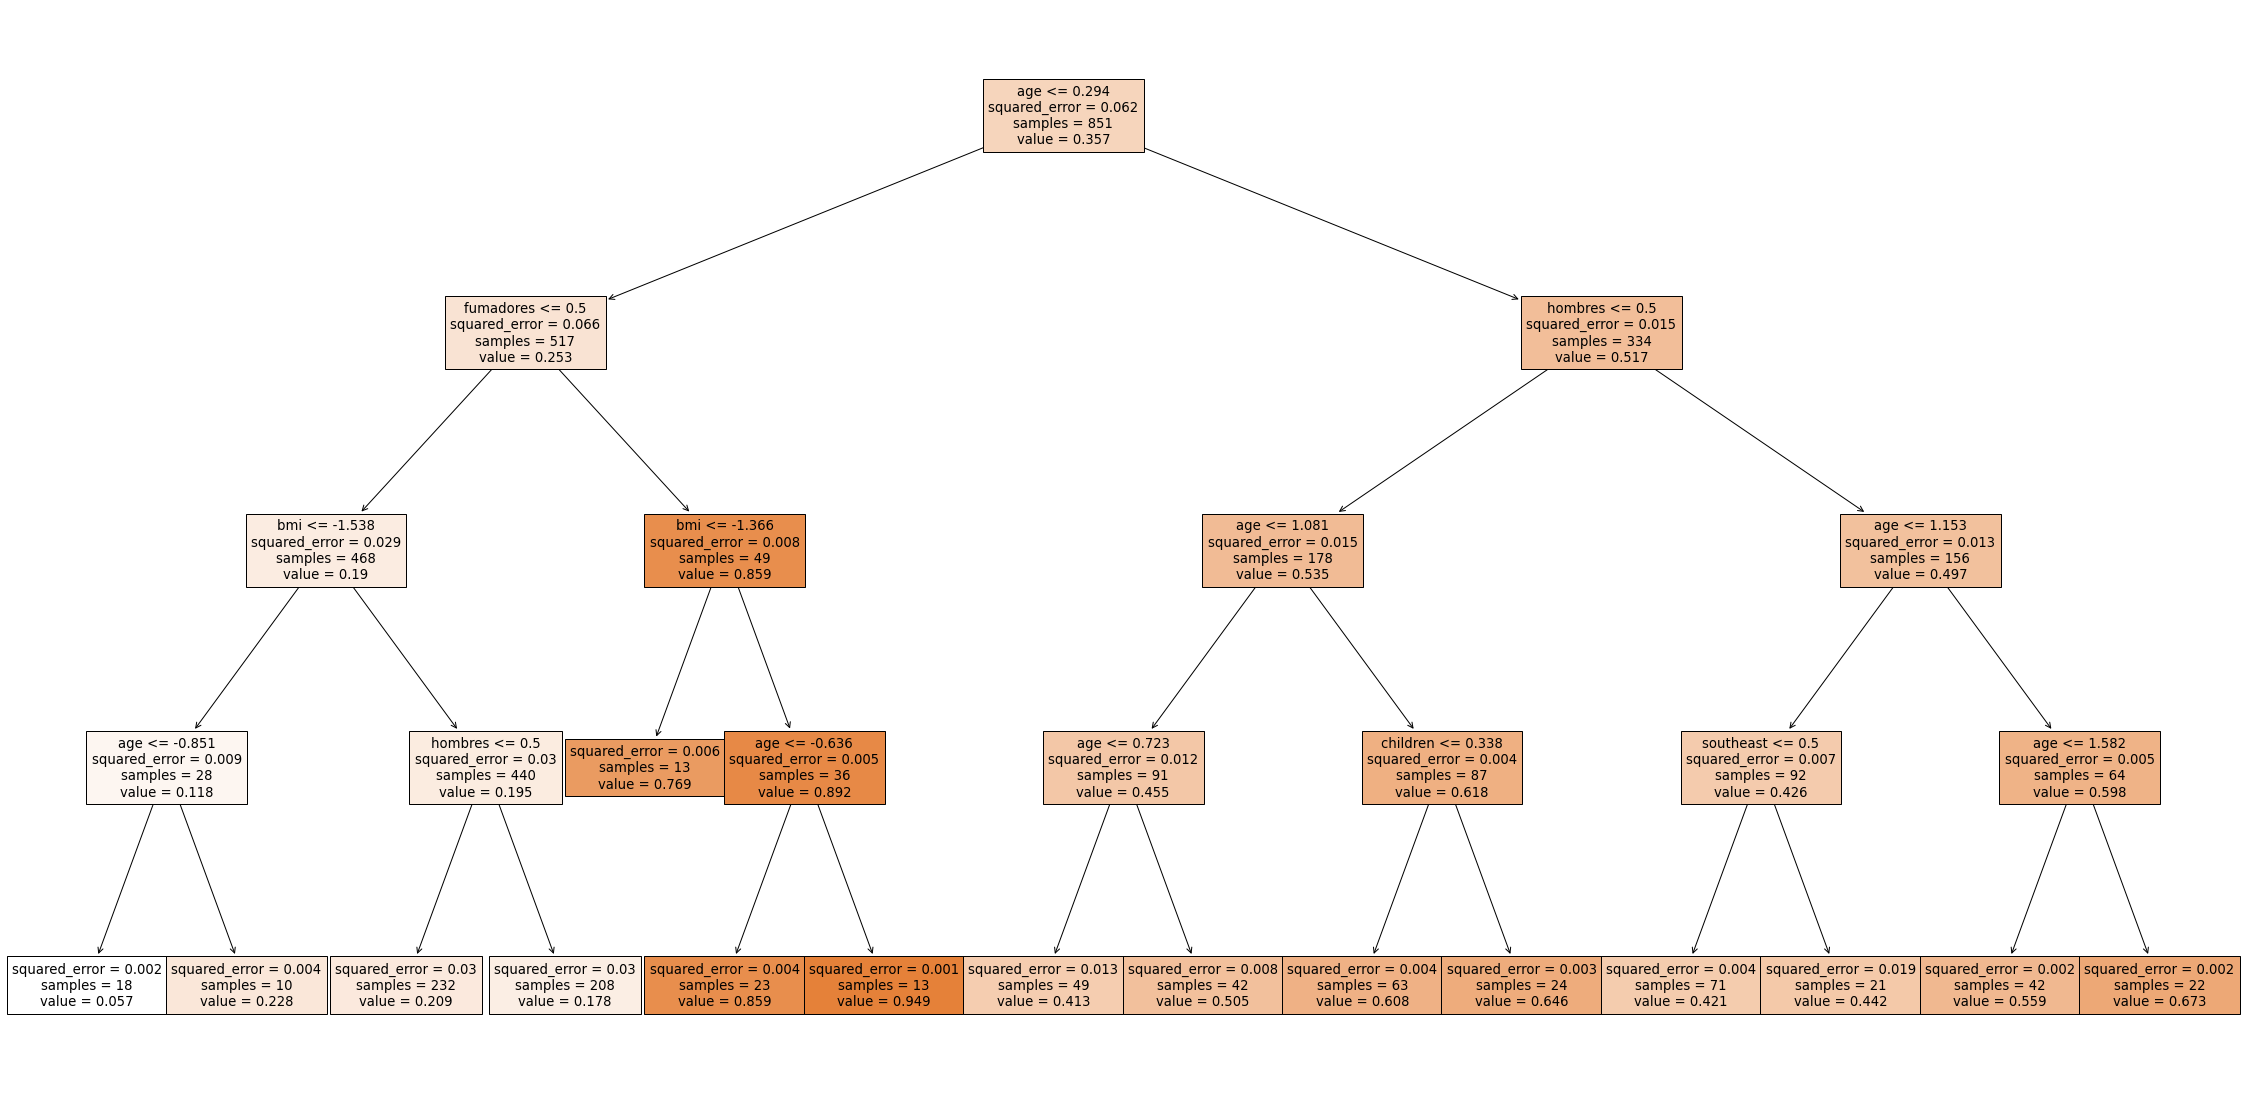

In [16]:
# veamos ahora que pinta tiene nuestro árbol


fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo, feature_names=x_train.columns, filled=True);

In [17]:
y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

In [18]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2



,MAE,MSE,RMSE,R2,set,modelo
0,0.094908,0.024417,0.156259,0.615704,test,Decision tree II
1,0.084392,0.018095,0.134519,0.708635,train,Decision tree II


In [19]:

# vamos a crearnos un dataframe 
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': mejor_modelo.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores


Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
3,fumadores,0.530046
0,age,0.454904
1,bmi,0.008029
4,hombres,0.006154
2,children,0.000679
7,southeast,0.000188
5,northeast,0.000000
6,northwest,0.000000
8,southwest,0.000000


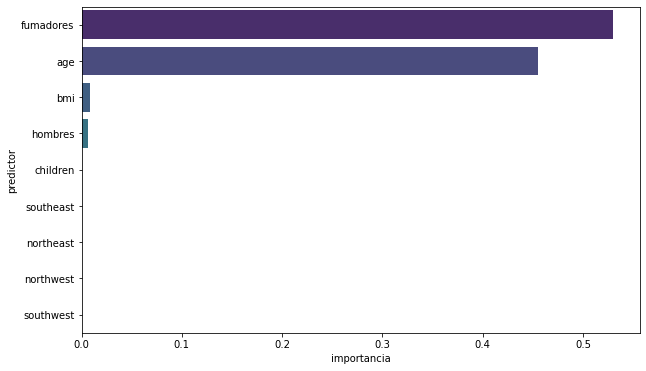

In [20]:
# por último ploteamos los resultados para verlo de una forma más amigable. 

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()

Resultado:

- Despues de correr varias veces el código, tenemos en todos los arboles algo de overfitting, 
- cambiamos la profundidad, y no nos resuelve el problema 
- en los que la r2 se nos reduce casi al 50,pasamos de valores predictorios de 0.72 a valores de 0.5.
- Aun asi, nos sigue saliendo algo de overfitting. 
- En todos los casos, nos ordena las variables predictoras segun importancia igual: edad>tabaco>hijos
- El modelo que mejores resultados nos sigue dando, es la regresión lineal, despues, decisión tree II

In [21]:
# vamos  a juntar los dataframes de los resultados de los modelos para poder compararlos mejor

df_decision_results_bajas = pd.concat([dt_results_bajas, dt_results2], axis = 0)
df_decision_results_bajas

,MAE,MSE,RMSE,R2,set,modelo
0,0.073463,0.035012,0.187114,0.448955,test,Decission Tree I
1,0.000780,0.000259,0.016081,0.995836,train,Decission Tree I
0,0.094908,0.024417,0.156259,0.615704,test,Decision tree II
1,0.084392,0.018095,0.134519,0.708635,train,Decision tree II


In [22]:
df_decision_results_bajas.to_csv('../data/11-df_decision_results_bajas.csv')

---

## Primas altas

In [23]:
# al igual que en la regresión lineal tenemos que separar nuestro dataframe en X e y

X2 = df2.select_dtypes(np.number).drop("charges", axis = 1)
y2 = df2["charges"]

In [24]:
# y dividir nuestros datos en train y test para poder evaluar la bondad de nuestro modelo

x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.2, random_state = 42)

In [25]:
# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol2 = DecisionTreeRegressor(random_state =0)

# ajustamos el modelo, igual que en la regresión lienal. 
arbol2.fit(x_train2, y_train2)



DecisionTreeRegressor(random_state=0)

In [26]:

# max depth

print(arbol2.tree_.max_depth)

15


In [27]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_dt2 = arbol2.predict(x_test2)
y_pred_train_dt2 = arbol2.predict(x_train2)

In [28]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results_altas = metricas(y_test2, y_train2, y_pred_test_dt2, y_pred_train_dt2, "Decission Tree I")
dt_results_altas

,MAE,MSE,RMSE,R2,set,modelo
0,2953.70266,3.247707e+07,5698.865839,0.685491,test,Decission Tree I
1,0.00000,0.000000e+00,0.000000,1.000000,train,Decission Tree I


---------------
Recordemos cuando había *overfitting* o *overfitting* 

- Si los valores del *train* son MUCHO MEJOR (que es tener métricas más bajas, excepto en el R² que sería tener valores más altos) que los del *test* --> ***overfitting***. En este caso, nuestro modelo se estaría aprendiendo de memoria los datos de entrenamiento y no sería capaz de hacer buenas predicciones fuera de ese set de datos.

- Si los valores del *train* son MUCHO PEOR (valores de las métricas más altas, excepto en el R² que sería tener valores más bajos) que los del *test* --> ***underfitting***. En este caso, nuestro modelo no es lo suficientemente bueno para generalizar a los datos de test ni para modelar decentemente los del *train*.

-------------------

Resultado: 

        Tenemos overfitting

---

In [29]:
# max features. Como vemos, debemos poner en nuestro modelo una profudidad máxima de 2/3. 

max_features2 = np.sqrt(len(x_train2.columns))
max_features2

2.449489742783178

In [30]:
# lo primero que tenemos que hacer es definir un diccionario con los hiperparámetros que queremos modificar y los valores que queremos 

param2 = {"max_depth": [2,3], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, la nuestra
                       # anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2,3,4],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos 
                         #como límite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [10, 25, 50],
        "min_samples_leaf": [10,25,50]} 


In [31]:
# una vez creado el diccionario iniciaremos el modelo con GridSearch

gs2 = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param2, # que hiperparámetros queremos que testee
            cv=5, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1, # para que no nos printee ningún mensaje en pantalla
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

In [32]:
# ajustamos el modelo que acabamos de definir en el GridSearch

gs2.fit(x_train2, y_train2)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 3], 'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 25, 50],
                         'min_samples_split': [10, 25, 50]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [33]:
# este método nos esta diciendo que el mejor modelo es aquel que tiene una profundidad de 3, que usa 4 variables predictoras para construir 
#el modelo y que tiene  un min_samples_leaf de 10 y un min_samples_split de 25. 
mejor_modelo2 = gs2.best_estimator_
mejor_modelo2

DecisionTreeRegressor(max_depth=3, max_features=4, min_samples_leaf=10,
                      min_samples_split=25)

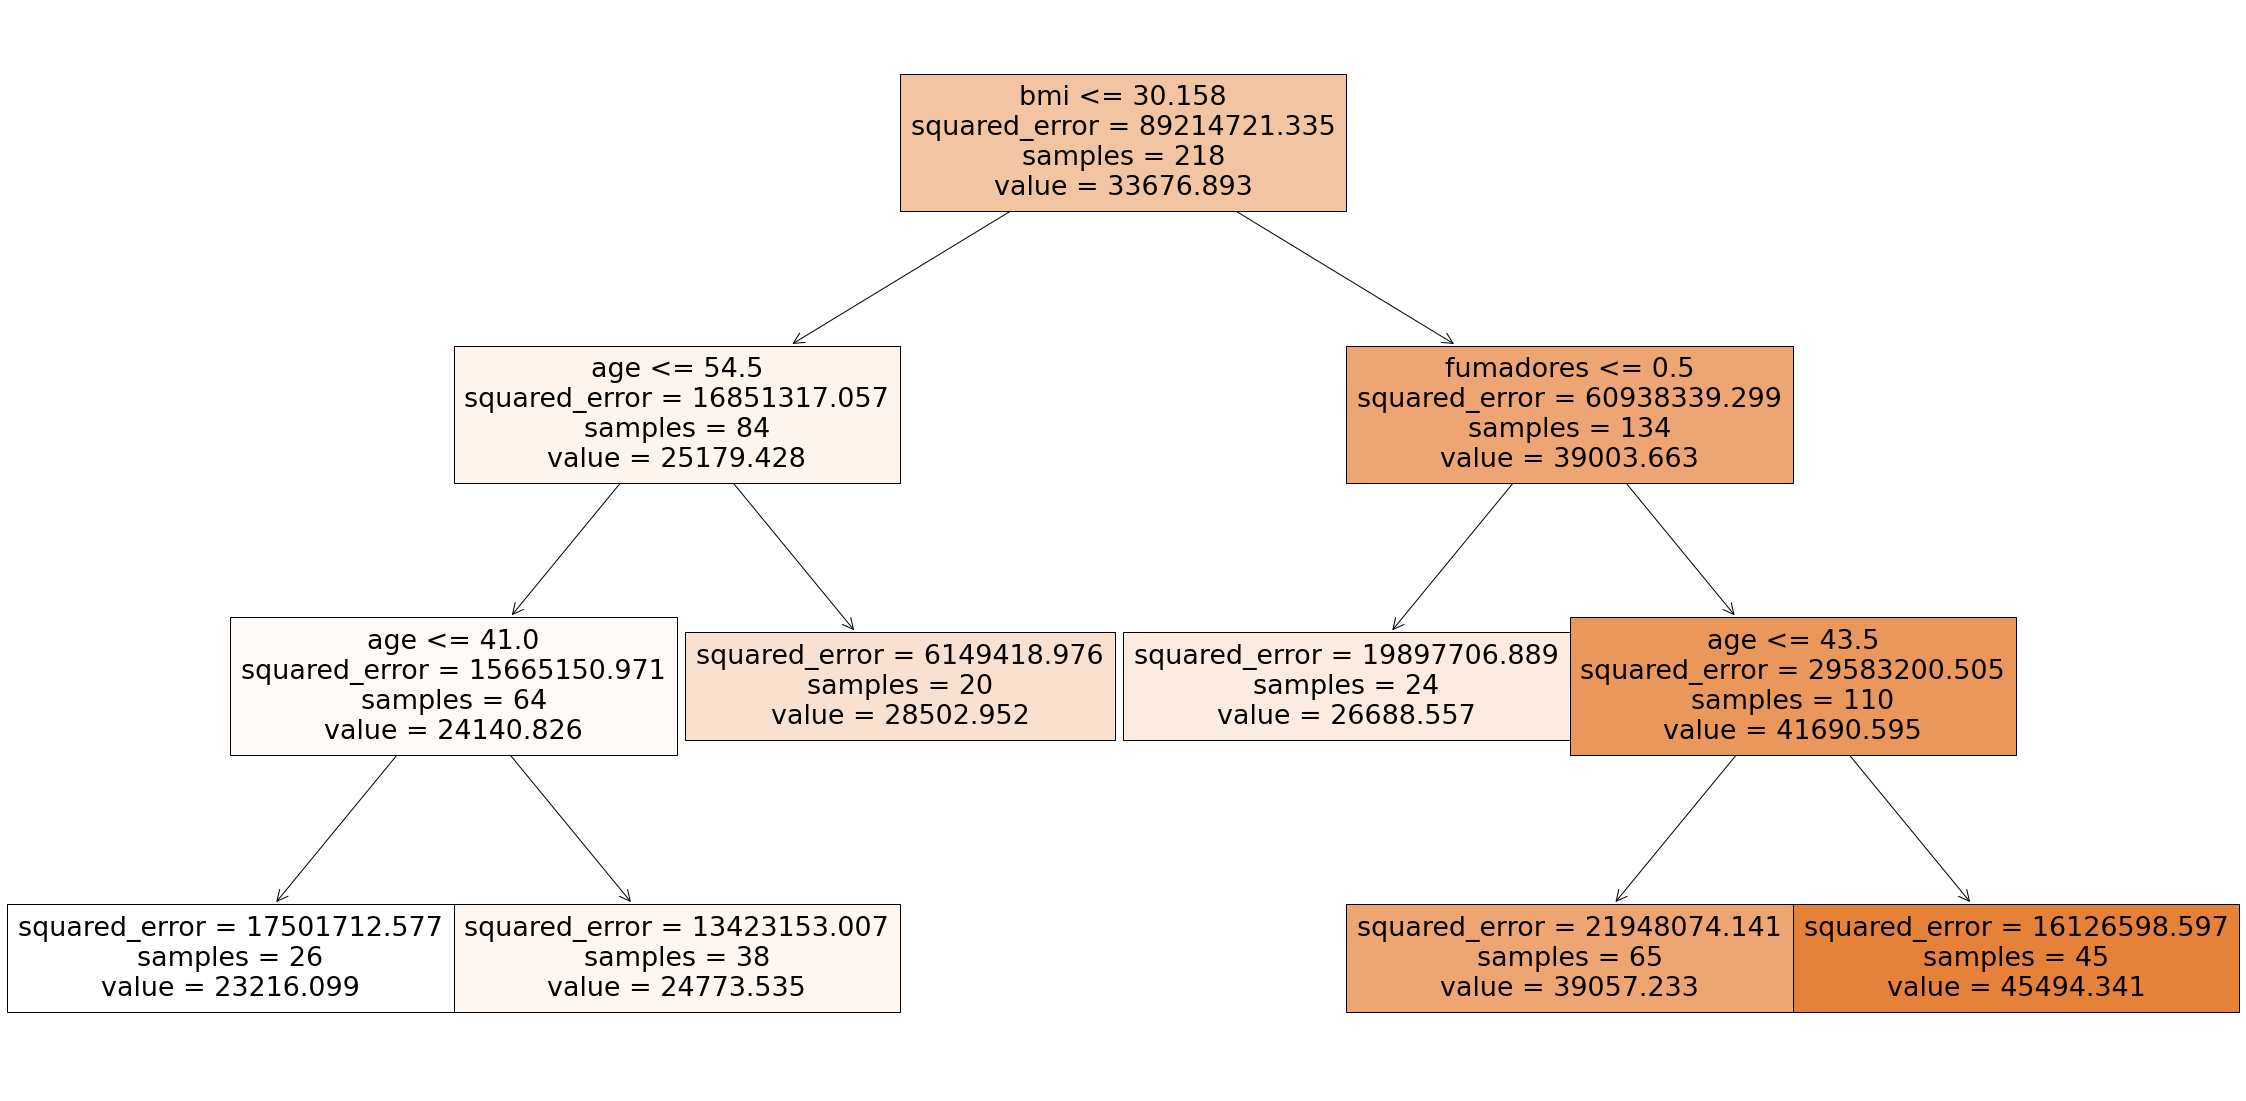

In [34]:
# veamos ahora que pinta tiene nuestro árbol


fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo2, feature_names=x_train2.columns, filled=True);

In [35]:
y_pred_test_dt2 = mejor_modelo2.predict(x_test2)
y_pred_train_dt2 = mejor_modelo2.predict(x_train2)

In [36]:
dt_results2 = metricas(y_test2, y_train2, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2



,MAE,MSE,RMSE,R2,set,modelo
0,3480.236405,2.334120e+07,4831.272614,0.773963,test,Decision tree II
1,2892.902567,1.705495e+07,4129.764106,0.808833,train,Decision tree II


In [37]:

# vamos a crearnos un dataframe 
importancia_predictores2 = pd.DataFrame(
                            {'predictor': x_train2.columns,
                             'importancia': mejor_modelo2.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores2.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores2


Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
1,bmi,0.627275
3,fumadores,0.281869
0,age,0.090855
2,children,0.000000
4,sex_female,0.000000
5,sex_male,0.000000


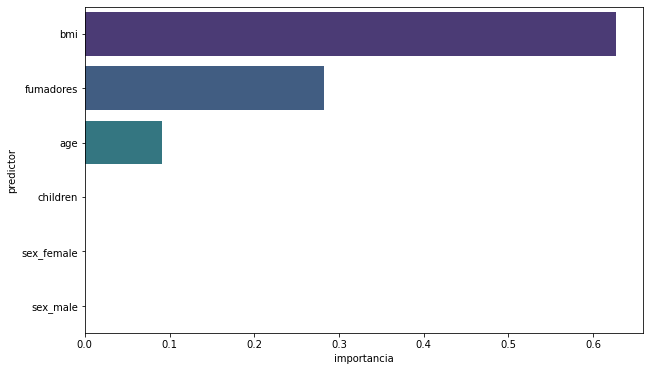

In [38]:
# por último ploteamos los resultados para verlo de una forma más amigable. 

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores2, palette="viridis");
plt.show()

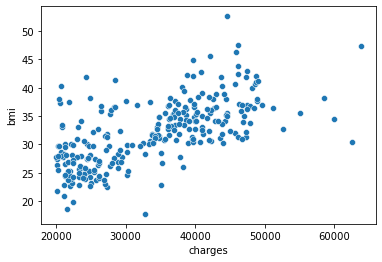

In [39]:
sns.scatterplot(x=df2['charges'], y=df2['bmi'], data=df2);

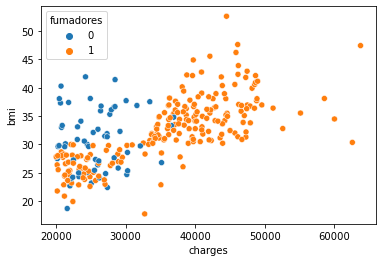

In [40]:
sns.scatterplot(x=df2['charges'], y=df2['bmi'], data=df2, hue=df2['fumadores']);

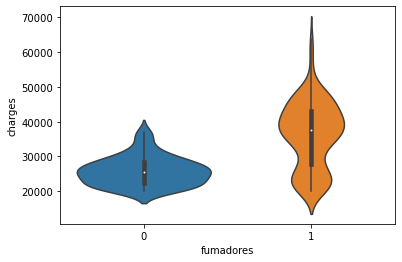

In [41]:
sns.violinplot(y=df2['charges'], x=df2['fumadores'], data=df2);

In [42]:
df2.corr()

,age,bmi,children,charges,fumadores,sex_female,sex_male
age,1.000000,-0.107578,0.028092,0.072790,-0.103686,0.048999,-0.048999
bmi,-0.107578,1.000000,0.046876,0.644481,0.131032,-0.081613,0.081613
children,0.028092,0.046876,1.000000,0.039187,-0.013573,-0.050136,0.050136
charges,0.072790,0.644481,0.039187,1.000000,0.454657,-0.072232,0.072232
fumadores,-0.103686,0.131032,-0.013573,0.454657,1.000000,-0.094462,0.094462
sex_female,0.048999,-0.081613,-0.050136,-0.072232,-0.094462,1.000000,-1.000000
sex_male,-0.048999,0.081613,0.050136,0.072232,0.094462,-1.000000,1.000000


In [43]:
primas_bmi=pd.DataFrame(pd.crosstab(df2['charges'],df2['bmi']).apply(lambda x:round(x*100/x.sum(), 2), axis=0))
primas_bmi

bmi,17.765,18.715,19.950,20.900,21.800,22.420,22.610,22.705,22.880,22.895,...,42.350,42.750,42.900,43.890,44.880,45.540,46.200,47.410,47.600,52.580
charges,,,,,,,,,,,,,,,,,,,,,
20009.63365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20149.32290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20167.33603,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20177.67113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20234.85475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55135.40209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58571.07448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60021.39897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
chi2 = chi2_contingency(primas_bmi)
if chi2[1] <= .05:
    print(f"Existen diferencias significativas en las primas según el bmi, con una p de {round(chi2[1], 2)}")
else:
    print

Existen diferencias significativas en las primas según el bmi, con una p de 0.0


Resultado:

- ### Nos quedamos con este modelo, no tenemos overfitting, comprobamos las relaciones,
 - porque en el inicio, antes de dividir los dataset, el bmi no nos salia muy correlacionado con las primas.
 - En este caso, según poder de prediccion, nos quedamos con el modelo Decision TreeII, en el I tenemos un overfitting grande y bajo poder de predicción.

In [45]:
# vamos  a juntar los dataframes de los resultados de los modelos para poder compararlos mejor

df_decision_results_altas = pd.concat([dt_results_altas, dt_results2], axis = 0)
df_decision_results_altas

,MAE,MSE,RMSE,R2,set,modelo
0,2953.702660,3.247707e+07,5698.865839,0.685491,test,Decission Tree I
1,0.000000,0.000000e+00,0.000000,1.000000,train,Decission Tree I
0,3480.236405,2.334120e+07,4831.272614,0.773963,test,Decision tree II
1,2892.902567,1.705495e+07,4129.764106,0.808833,train,Decision tree II


In [46]:
df_decision_results_altas.to_csv('../data/11-df_decision_results_altas.csv')